<a href="https://colab.research.google.com/github/sahil-ansari-15/CAPSTONE-PROJECT-Identifying-optimal-Location-to-startup-Tuition-Classes-in-Mumbai/blob/main/Collaborative_filtering_Correlation_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Business Problem**

MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.      
The dataset can be downloaded from here  -- (https://grouplens.org/datasets/movielens/100k/)
This data set consists of: 
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
    * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from September 19th,1997 through April 22nd, 1998.

**Task and Approach:**

We need to work on the MovieLens dataset and build a model to recommend movies to the end users

**Step 1 :** Importing Libraries and Understanding Data

In [1]:
%matplotlib inline  
# To make data visualisations display in Jupyter Notebooks 
import numpy as np   # linear algebra
import pandas as pd  # Data processing, Input & Output load
import matplotlib.pyplot as plt # Visuvalization & plotting
import seaborn as sns # Also for Data visuvalization 

from sklearn.metrics.pairwise import cosine_similarity  # Compute cosine similarity between samples in X and Y.
from scipy import sparse  #  sparse matrix package for numeric data.
from scipy.sparse.linalg import svds # svd algorithm

import warnings   # To avoid warning messages in the code run
warnings.filterwarnings("ignore")


**Step 2 :** Loading Data  & Corss chekcing 

In [2]:
Rating = pd.read_csv('Ratings.csv') 
Movie_D = pd.read_csv('Movie details.csv',encoding='latin-1') ##Movie details 
User_Info = pd.read_csv('user level info.csv',encoding='latin-1') ## if you have a unicode string, you can use encode to convert

In [3]:
Rating.shape

(100000, 4)

In [4]:
Rating.head()

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


* Item id means it is Movie id 
* Item_ID chnaged as Movie id for the better redability pupose 


In [5]:
Rating.columns = ['user_id', 'movie_id', 'rating', 'timestamp'] 

Renaming the columns to avoid the space in the column name text 

In [6]:
Rating.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
Movie_D.shape

(1682, 24)

In [8]:
Movie_D.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
Movie_D.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date ',
       'IMDb_URL', 'unknown', 'Action ', 'Adventure', 'Animation',
       'Childrens', 'Comedy ', 'Crime ', ' Documentary ', 'Drama',
       ' Fantasy', 'Film-Noir ', 'Horror ', 'Musical', 'Mystery',
       ' Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Renaming the columns to avoid the space in the column name text 

In [10]:
Movie_D.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


**To get our desired information in a single dataframe, we can merge the two dataframes objects on the movie_Id column since it is common between the two dataframes.**

**We can do this using merge() function from the Pandas library**

In [11]:
Movie_Rating = pd.merge(Rating ,Movie_D,on = 'movie_id')
Movie_Rating.describe()

,user_id,movie_id,rating,timestamp,video_release_date,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,100000.00000,100000.000000,100000.000000,1.000000e+05,0.0,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860,8.835289e+08,NaN,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,0.007580,0.398950,0.013520,0.017330,0.053170,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540
std,266.61442,330.798356,1.125674,5.343856e+06,NaN,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,0.086733,0.489685,0.115487,0.130498,0.224373,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894
min,1.00000,1.000000,1.000000,8.747247e+08,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,254.00000,175.000000,3.000000,8.794487e+08,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,447.00000,322.000000,4.000000,8.828269e+08,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,682.00000,631.000000,4.000000,8.882600e+08,NaN,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
max,943.00000,1682.000000,5.000000,8.932866e+08,NaN,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


In [12]:
Movie_Rating.to_csv("Movie_Rating.csv")

**We can see the Average rating for all the movie is 3.5**              
**We can also see 25 percentile also indicating avaerage is 3 highest is 5**

In [13]:
n_users = Movie_Rating.user_id.unique().shape[0]
n_items = Movie_Rating.movie_id.unique().shape[0]
print(n_users,n_items)

943 1682


No of unique users & No of unique Movies 

In [14]:
# Calculate mean rating of all movies 
Movie_Stats = pd.DataFrame(Movie_Rating.groupby('movie_title')['rating'].mean())
Movie_Stats.sort_values(by = ['rating'],ascending=False).head()

,rating
movie_title,
They Made Me a Criminal (1939),5.0
Marlene Dietrich: Shadow and Light (1996),5.0
"Saint of Fort Washington, The (1993)",5.0
Someone Else's America (1995),5.0
Star Kid (1997),5.0


**Let's now plot the total number of ratings for a movie**

In [15]:
# Calculate count rating of all movies 

Movie_Stats['No_of_user_rated'] = pd.DataFrame(Movie_Rating.groupby('movie_title')['rating'].count())
Movie_Stats.sort_values(by =['No_of_user_rated'], ascending=False).head()

,rating,No_of_user_rated
movie_title,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485


**Now we know that both the average rating per movie and the number of ratings per movie are important attributes**

**Plot a histogram for the number of ratings**

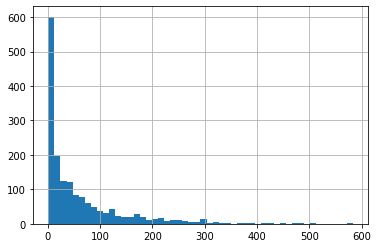

In [16]:
Movie_Stats['No_of_user_rated'].hist(bins=50)

**From the output, you can see that most of the movies have received less than 50 ratings.**
It is evident that the data has a weak normal distribution with the mean of around 3.5. There are a few outliers in the data

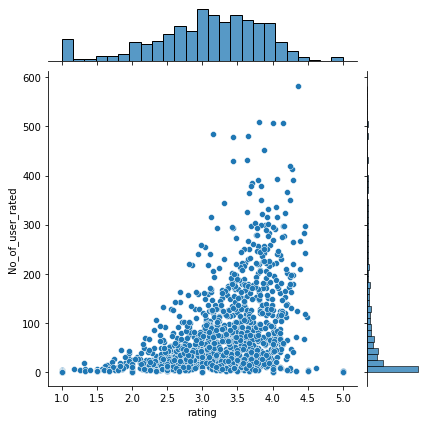

In [17]:
sns.jointplot(x='rating', y='No_of_user_rated', data=Movie_Stats)

* The graph shows that, in general, movies with higher average ratings actually have more number of ratings, compared with movies that have lower average ratings.

 ### Finding Similarities Between Movies

* We will use the correlation between the ratings of a movie as the similarity metric.
* To see the corrilation we will create Pivot table between user_id ,movies, ratings

Movie_Rating.to_csv("Movie_Rating.csv") 

In [18]:
User_movie_Rating = Movie_Rating.pivot_table(index='user_id', columns='movie_title', values='rating')
User_movie_Rating.head()

movie_title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


In [19]:
##We can achieve this by computing the correlation between these two movies ratings and the ratings of the rest of the movies in the dataset. 
##The first step is to create a dataframe with the ratings of these movies 

# Example pick up one movie related rating  
User_movie_Rating['Air Force One (1997)']

user_id
1      NaN
2      4.0
3      2.0
4      5.0
5      NaN
      ... 
939    NaN
940    5.0
941    4.0
942    5.0
943    NaN
Name: Air Force One (1997), Length: 943, dtype: float64

## Correlation Similarity

* We can find the correlation between the user ratings for the **given movie**  and all the other movies using corrwith() function as shown below:

* it used normal pearson correlation value where the data is match 

In [20]:
Similarity = User_movie_Rating.corrwith(User_movie_Rating['Air Force One (1997)'])
Similarity.head()

movie_title
'Til There Was You (1997)    0.867722
1-900 (1994)                      NaN
101 Dalmatians (1996)        0.221943
12 Angry Men (1957)          0.228031
187 (1997)                   0.294232
dtype: float64

In [21]:
corr_similar = pd.DataFrame(Similarity, columns=['Correlation'])
corr_similar.sort_values(['Correlation'], ascending= False).head(10)

,Correlation
movie_title,
Love and Death on Long Island (1997),1.0
Losing Chase (1996),1.0
Phat Beach (1996),1.0
My Crazy Life (Mi vida loca) (1993),1.0
Tetsuo II: Body Hammer (1992),1.0
Jack and Sarah (1995),1.0
Vermin (1998),1.0
Faster Pussycat! Kill! Kill! (1965),1.0
For Ever Mozart (1996),1.0


#### We will add the count of rating also to see why many movies are exactly correlating for the single movie 

In [22]:
corr_similar_num_of_rating = corr_similar.join(Movie_Stats['No_of_user_rated'])
corr_similar_num_of_rating.sort_values(['Correlation'], ascending= False).head(10)

,Correlation,No_of_user_rated
movie_title,,
Love and Death on Long Island (1997),1.0,2
Losing Chase (1996),1.0,8
Phat Beach (1996),1.0,5
My Crazy Life (Mi vida loca) (1993),1.0,11
Tetsuo II: Body Hammer (1992),1.0,6
Jack and Sarah (1995),1.0,7
Vermin (1998),1.0,2
Faster Pussycat! Kill! Kill! (1965),1.0,7
For Ever Mozart (1996),1.0,3


* We can able to see  that a movie cannot be declared similar to the another movie based on just 2 or 3  ratings. 

* This is why we need to filter  movies correlated to given movie  that have more than 30/50 ratings

In [23]:
corr_similar_num_of_rating[corr_similar_num_of_rating ['No_of_user_rated']>50].sort_values('Correlation', ascending=False).head()

,Correlation,No_of_user_rated
movie_title,,
Air Force One (1997),1.000000,431
Black Sheep (1996),0.766259,55
Copycat (1995),0.711744,86
Tales from the Crypt Presents: Bordello of Blood (1996),0.639372,55
Addicted to Love (1997),0.576379,54


**Creation the user defined function to get the similar movies to recommend**
* All the above steps created as one UDF so that we can pass the movie title and get the recomendations


In [24]:
def get_recommendations(title):
    # Get the movie ratings of the movie that matches the title
    Movie_rating = User_movie_Rating[title]

    # Get the  similarity corrilated  scores of all movies with that movie
    sim_scores = User_movie_Rating.corrwith(Movie_rating)

    # Sort the movies based on the similarity scores
    corr_title = pd.DataFrame(sim_scores, columns=['Correlation'])
    
    # Removing na values 
    corr_title.dropna(inplace=True)
    
    corr_title = corr_title.join(Movie_Stats['No_of_user_rated'])
    
    # Return the top 10 most similar movies
    return corr_title[corr_title ['No_of_user_rated']>50].sort_values('Correlation', ascending=False).head()

In [25]:
# Usage of the above function
get_recommendations('Air Force One (1997)')

,Correlation,No_of_user_rated
movie_title,,
Air Force One (1997),1.000000,431
Black Sheep (1996),0.766259,55
Copycat (1995),0.711744,86
Tales from the Crypt Presents: Bordello of Blood (1996),0.639372,55
Addicted to Love (1997),0.576379,54


In [26]:
get_recommendations('Star Wars (1977)')

,Correlation,No_of_user_rated
movie_title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Giant (1956),0.488093,51
